In [133]:
import pandas as pd
import re
import numpy as np
import plotly.graph_objects as go
import urllib, json
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

## Import data

In [3]:
folder = "C:/Users/samspencer/OneDrive - Royal Town Planning Institute/Documents/Projects/Prior Approvals/"

# Read in prior approval data from local directory

priors = 'Prior approvals for analysis 20211215'

df = pd.read_excel(folder + priors+'.xlsx')

In [4]:
df.head(3)

,id,Application type on Datahub,Application type (assumed),Development description,Status (groups),Status,Decision,Easting,Northing,postcode,...,Application number,Valid date,Decision date,Residential units proposed,Existing use class (from Datahub),Existing non-residential floorspace,High Street name,Town Centre Name,Planned Article 4 Direction,Adopted OA name
0,Barking_&_Dagenham-13_00560_CLU_P,Prior Approval: Change of use - retail/takeawa...,Prior Approval: Change of use - retail/takeawa...,Application for a certificate of lawfulness fo...,Allowed,Superseded,NaN,549303.0,183999.0,RM10 9JA,...,13/00560/CLU_P,NaT,2013-09-10 00:00:00,2.0,A1,100.0,"Broad Street, Dagenham.",NaN,NaN,NaN
1,Barking_&_Dagenham-13_01133_PRIOR,Prior Approval: Change of use - offices to dwe...,Prior Approval: Change of use - offices to dwe...,Application for prior approval of proposed cha...,Allowed,Lapsed,NaN,547748.0,187941.0,RM6 6PY,...,13/01133/PRIOR,NaT,2014-02-11 00:00:00,2.0,B1a,151.0,"High Road, Seven Kings.",Chadwell Heath,NaN,NaN
2,Barking_&_Dagenham-13_01151_PRIOR,Prior Approval: Change of use - offices to dwe...,Prior Approval: Change of use - offices to dwe...,Application for prior approval of change of us...,Allowed,Lapsed,NaN,543692.0,184058.0,IG11 8BB,...,13/01151/PRIOR,NaT,2014-03-03 00:00:00,44.0,B1a,3183.0,NaN,NaN,NaN,London Riverside


In [7]:
df.columns

Index(['id', 'Application type on Datahub', 'Application type (assumed)',
       'Development description', 'Status (groups)', 'Status', 'Decision',
       'Easting', 'Northing', 'postcode', 'Planning authority',
       'Application number', 'Valid date', 'Decision date',
       'Residential units proposed', 'Existing use class (from Datahub)',
       'Existing non-residential floorspace', 'High Street name',
       'Town Centre Name', 'Planned Article 4 Direction', 'Adopted OA name'],
      dtype='object')

In [8]:
df['Planning authority'].value_counts()

Ealing                    5902
Barnet                    2474
Richmond                  2423
Enfield                   1662
Brent                     1471
Bromley                   1308
Havering                  1304
Croydon                   1293
Hillingdon                1038
Sutton                     925
Lewisham                   912
Merton                     888
Newham                     887
Kingston                   837
Harrow                     798
Greenwich                  753
Bexley                     713
Lambeth                    684
Hackney                    419
Hammersmith & Fulham       408
Wandsworth                 377
Southwark                  350
Camden                     318
Tower Hamlets              303
Haringey                   284
Redbridge                  247
Hounslow                   232
Islington                  217
Westminster                142
Waltham Forest             132
Kensington & Chelsea        48
Barking & Dagenham          35
City of 

In [ ]:
# Kensington and Chelsea particularly low

In [9]:
df['Application type on Datahub'].value_counts(dropna = False)

NaN                                                                              20241
Prior Approval: Change of use - offices to dwellinghouses                         4454
Prior Approval: Larger Home Extension                                             3101
Lawful development: Proposed use                                                   676
Prior Approval: Change of use - retail/takeaway to dwellinghouses                  641
Prior Approval: Development for electronic communications network                  224
Prior Approval: Change of use - storage to dwellinghouses                          184
Prior Approval: Change of use - retail/service/takeaway/etc to dwellinghouses      127
Prior Approval: Change of use - retail/service/etc to restaurant/café               44
Lawful development: Existing use                                                    35
Prior Approval: Change of use - business/hotels/etc to school/nursery               21
Full planning permission                   

In [10]:
df['Application type (assumed)'].value_counts(dropna = False)

Prior Approval: Larger Home Extension                                                                                 19342
Prior Approval: Change of use - offices to dwellinghouses                                                              5120
Lawful development: Proposed use                                                                                       1066
Prior Approval: Development for electronic communications network                                                      1036
Prior Approval: Change of use - retail/takeaway to dwellinghouses                                                       662
Retail to residential                                                                                                   371
New dwelling on existing building                                                                                       321
Prior Approval: Change of use - retail/service/etc to restaurant/café                                                   272
Prior Ap

In [ ]:
df.tail(3)

## Clean Change of Use Fields

A significant amount of rows lack a value for 'application_type_full' so where those values are null, we need to replace it with the 'Assumed application type' value

In [11]:
df['Application type on Datahub'] = df['Application type on Datahub'].apply(lambda x: None if isinstance(x,float) else x)

df['application_type_new'] = df.apply(lambda x: x['Application type on Datahub'] if x['Application type on Datahub'] else x['Application type (assumed)'], axis = 1)

In [29]:
df['application_type_new'].value_counts(dropna = False)

Prior Approval: Larger Home Extension                                                                                 19342
Prior Approval: Change of use - offices to dwellinghouses                                                              5120
Lawful development: Proposed use                                                                                       1066
Prior Approval: Development for electronic communications network                                                      1036
Prior Approval: Change of use - retail/takeaway to dwellinghouses                                                       662
Retail to residential                                                                                                   371
New dwelling on existing building                                                                                       321
Prior Approval: Change of use - retail/service/etc to restaurant/café                                                   272
Prior Ap

Need to build a capability to catch exceptions and standardise the format of all prior approvals. For example, the title "Retail to residential" wouldn't be captured in the below code

In [46]:
def split_change(text):
    changed_from = None
    changed_to = None
    if isinstance(text, str):
        if ' to ' in text and ' - ' in text:
            split = re.split(r' to ', text)
            changed_to = split[1]
            changed_from = re.split(r' - ',split[0])[1]
    return (changed_to, changed_from)      

In [47]:
### Apply function to split change to before/after

df['changes'] = df['application_type_new'].apply(lambda x: split_change(x))

df['changed_from'] = df['changes'].apply(lambda x: x[1])

df['changed_to'] = df['changes'].apply(lambda x: x[0])

In [48]:
non_null_df = df[df['changes']!= (None, None)]

In [49]:
non_null_df['changes'].value_counts()

(dwellinghouses, offices)                                    5120
(dwellinghouses, retail/takeaway)                             662
(restaurant/café, retail/service/etc)                         272
(dwellinghouses, storage)                                     211
(dwellinghouses, retail/service/takeaway/etc)                 133
(dwellinghouses, commercial/business/service)                 127
(dwellinghouses, light industrial)                             78
(school/nursery, business/hotels/etc)                          56
(assembly/leisure, retail/service/etc)                         18
(dwellinghouses, agriculture)                                  16
(restaurant/café, retail)                                      11
(offices, retail/service/takeaway/etc)                          9
(dwellinghouses, amusements/casinos)                            8
(business/hotels/etc, school/nursery)                           2
(mixed use including up, commercial/business/service/etc)       1
Name: chan

In [89]:
# Quick function to clean up the formatting of the to/from labels
# Important bit is to add the extra space to some labels (either to or from) to make it different, otherwise Sankey chart will be distorted


def clean_labels(x):
    to = x[0]
    fr = x[1]
    to = to.capitalize()
    fr = fr.capitalize()
    to += ' '
    return (to, fr)

In [90]:
change_df = pd.DataFrame(non_null_df['changes'].value_counts()).reset_index()
change_df['index'] = change_df['index'].apply(lambda x: clean_labels(x))
change_df['changed_to'] = change_df['index'].apply(lambda x: x[0])
change_df['changed_from'] = change_df['index'].apply(lambda x: x[1])
change_df

,index,changes,changed_to,changed_from
0,"(Dwellinghouses , Offices)",5120,Dwellinghouses,Offices
1,"(Dwellinghouses , Retail/takeaway)",662,Dwellinghouses,Retail/takeaway
2,"(Restaurant/café , Retail/service/etc)",272,Restaurant/café,Retail/service/etc
3,"(Dwellinghouses , Storage)",211,Dwellinghouses,Storage
4,"(Dwellinghouses , Retail/service/takeaway/etc)",133,Dwellinghouses,Retail/service/takeaway/etc
5,"(Dwellinghouses , Commercial/business/service)",127,Dwellinghouses,Commercial/business/service
6,"(Dwellinghouses , Light industrial)",78,Dwellinghouses,Light industrial
7,"(School/nursery , Business/hotels/etc)",56,School/nursery,Business/hotels/etc
8,"(Assembly/leisure , Retail/service/etc)",18,Assembly/leisure,Retail/service/etc
9,"(Dwellinghouses , Agriculture)",16,Dwellinghouses,Agriculture


In [ ]:
tabs = pd.crosstab(non_null_df['changes'],non_null_df['lpa_name'],margins = True)

In [ ]:
tabs_pct = pd.crosstab(non_null_df['changes'],non_null_df['lpa_name'], normalize = 'index',margins = True)

In [ ]:
tabs_pct

In [ ]:
tabs

In [93]:
types = list(set(list(change_df['changed_to'])+list(change_df['changed_from'])))

value_dict = dict(zip(change_df['index'], change_df['changes']))

In [97]:
fig = go.Figure(data=[go.Sankey(
    # Define nodes
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
        label = types
    ),
    # Add links
    link = dict(
      source =  [types.index(x) for x in change_df['changed_from']],
      target =  [types.index(x) for x in change_df['changed_to']],
      value =  [value_dict[x] for x in zip(change_df['changed_to'],change_df['changed_from'])],
    label = [value_dict[x] for x in zip(change_df['changed_to'],change_df['changed_from'])]))])
    #  color =  data['data'][0]['link']['color']
#))])

fig.update_layout(title_text="Prior Approvals - Change of Use",font_size=10)
fig.show()

## Residential Conversions

In [ ]:
## Use "decision_date" or "valid_date" ?

## Combination of the two where 

In [127]:
df.columns

Index(['id', 'Application type on Datahub', 'Application type (assumed)',
       'Development description', 'Status (groups)', 'Status', 'Decision',
       'Easting', 'Northing', 'postcode', 'Planning authority',
       'Application number', 'Valid date', 'Decision date',
       'Residential units proposed', 'Existing use class (from Datahub)',
       'Existing non-residential floorspace', 'High Street name',
       'Town Centre Name', 'Planned Article 4 Direction', 'Adopted OA name',
       'application_type_new', 'changes', 'changed_from', 'changed_to', 'date',
       'month_year', 'residential_conversion'],
      dtype='object')

In [150]:
df['Valid date'].value_counts(dropna = False)

NaT           6282
2021-04-07      55
2021-04-01      54
2021-04-09      49
2020-10-19      49
              ... 
2014-07-29       1
2020-03-22       1
2016-07-26       1
2018-02-07       1
2021-10-17       1
Name: Valid date, Length: 2321, dtype: int64

In [151]:
### Convert time to Month-Year

# Where the value for 'Decision date' is null, replace it with 'Valid date'
df['date'] = np.where(pd.to_datetime(df['Decision date']).isnull(),pd.to_datetime(df['Valid date']),pd.to_datetime(df['Decision date']))

df['month_year'] = df['date'].apply(lambda x: x.strftime('%B-%Y') if x > pd.to_datetime("2000-12-30") else None )

In [155]:
### Flag Residential Conversions

# May need to change this logic later if conversion name changes

df['residential_conversion'] = df['changed_to'].apply(lambda x: True if x == "dwellinghouses" else False)

In [156]:
residential_converstions_monthly = df[df['residential_conversion']==True].groupby(['month_year','Planning authority']).agg({'id':'count'})

In [166]:
residential_converstions_monthly = df[df['residential_conversion']==True].groupby('month_year').agg({'id':'count','Residential units proposed':'sum','Existing non-residential floorspace':'median'})

residential_converstions_monthly = pd.DataFrame(residential_converstions_monthly).reset_index()
residential_converstions_monthly['month_year'] = pd.to_datetime(residential_converstions_monthly['month_year'], format = "%B-%Y")
residential_converstions_monthly = residential_converstions_monthly.sort_values('month_year')

residential_converstions_monthly =residential_converstions_monthly.dropna()
#residential_converstions_monthly['month_year'] = residential_converstions_monthly['month_year'].apply(lambda x: x.strftime('%B-%Y') if x > pd.to_datetime("2000-12-30") else None)

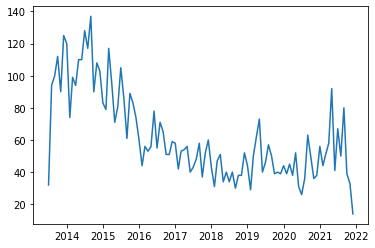

In [167]:
### Total residential conversions by month

# Doesn't appear that there have been a huge spike in residential converstions after August--but would be expecting a jump
# in August? Or just 2021?

# 

plt.plot(residential_converstions_monthly['month_year'],residential_converstions_monthly['id'])
plt.show()

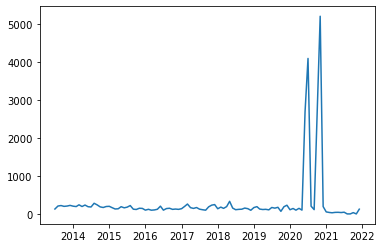

In [168]:
### Median non-residential floorspace by month

# Two months look like outliers--group annually to smooth?

plt.plot(residential_converstions_monthly['month_year'],residential_converstions_monthly['Existing non-residential floorspace'])
plt.show()

In [181]:
residential_converstions_monthly[['month_year','Existing non-residential floorspace']].tail(20)

,month_year,Existing non-residential floorspace
6,2020-04-01,147.000000
73,2020-05-01,100.000000
57,2020-06-01,2683.000000
49,2020-07-01,4092.500000
15,2020-08-01,204.000000
100,2020-09-01,113.000000
82,2020-11-01,5203.500000
24,2020-12-01,193.000000
41,2021-01-01,53.000000
33,2021-02-01,38.275000


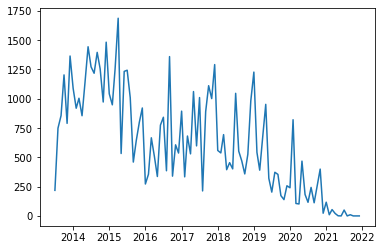

In [169]:
### Sum of 'Residential units proposed' by month

# Why 0 units in most recent months?

plt.plot(residential_converstions_monthly['month_year'],residential_converstions_monthly['Residential units proposed'])
plt.show()

In [164]:
residential_converstions_monthly

,month_year,id,Residential units proposed,Existing non-residential floorspace
42,2013-07-01,32,218.0,423.032258
8,2013-08-01,94,748.0,587.946237
93,2013-09-01,100,855.0,660.290000
84,2013-10-01,112,1202.0,785.261261
75,2013-11-01,90,789.0,527.100000
...,...,...,...,...
16,2021-08-01,50,0.0,160.629375
101,2021-09-01,80,10.0,75.447143
92,2021-10-01,39,0.0,44.666667
83,2021-11-01,33,0.0,0.000000


In [170]:
df.columns

Index(['id', 'Application type on Datahub', 'Application type (assumed)',
       'Development description', 'Status (groups)', 'Status', 'Decision',
       'Easting', 'Northing', 'postcode', 'Planning authority',
       'Application number', 'Valid date', 'Decision date',
       'Residential units proposed', 'Existing use class (from Datahub)',
       'Existing non-residential floorspace', 'High Street name',
       'Town Centre Name', 'Planned Article 4 Direction', 'Adopted OA name',
       'application_type_new', 'changes', 'changed_from', 'changed_to', 'date',
       'month_year', 'residential_conversion'],
      dtype='object')

### Map Changes over time

In [173]:
gdf = gpd.read_file(folder+'Local_Planning_Authorities_(April_2019)_UK_BUC.geojson')

In [175]:
gdf.head()

,objectid,lpa19cd,lpa19nm,bng_e,bng_n,long,lat,st_areashape,st_lengthshape,geometry
0,1,E60000001,County Durham LPA,410381,532242,-1.84050,54.685131,2.232342e+09,263945.945384,"POLYGON ((-1.55941 54.88204, -1.57991 54.87777..."
1,2,E60000002,Darlington LPA,428029,515648,-1.56835,54.535339,1.988128e+08,91926.839545,"POLYGON ((-1.43836 54.59508, -1.45171 54.59083..."
2,3,E60000003,Hartlepool LPA,447157,531476,-1.27023,54.676159,9.602794e+07,51062.316765,"POLYGON ((-1.24223 54.72296, -1.25186 54.71962..."
3,4,E60000004,Middlesbrough LPA,451141,516887,-1.21099,54.544670,5.523139e+07,35500.386745,"POLYGON ((-1.19860 54.58287, -1.25236 54.59131..."
4,5,E60000005,Northumberland LPA,397861,571351,-2.03501,55.036671,3.975207e+09,608805.111435,"MULTIPOLYGON (((-2.00158 55.77855, -2.03453 55..."


In [179]:
df['Planning authority'].unique()

array(['Barking & Dagenham', 'Barnet', 'Bexley', 'Brent', 'Bromley',
       'Camden', 'City of London', 'Croydon', 'Ealing', 'Enfield',
       'Greenwich', 'Hackney', 'Hammersmith and Fulham',
       'Hammersmith & Fulham', 'Haringey', 'Harrow', 'Havering',
       'Hillingdon', 'Hounslow', 'Islington', 'Kensington & Chelsea',
       'Kingston', 'Lambeth', 'Lewisham', 'LLDC', 'Merton', 'Newham',
       'OPDC', 'Redbridge', 'Richmond', 'Southwark', 'Sutton',
       'Tower Hamlets', 'Waltham Forest', 'Wandsworth', 'Westminster'],
      dtype=object)

In [176]:
gdf['lpa19nm'].unique()

array(['County Durham LPA', 'Darlington LPA', 'Hartlepool LPA',
       'Middlesbrough LPA', 'Northumberland LPA',
       'Redcar and Cleveland LPA', 'Stockton-on-Tees LPA',
       'Gateshead LPA', 'Newcastle upon Tyne LPA', 'North Tyneside LPA',
       'South Tyneside LPA', 'Sunderland LPA',
       'Blackburn with Darwen LPA', 'Blackpool LPA', 'Cheshire East LPA',
       'Cheshire West and Chester LPA', 'Halton LPA', 'Warrington LPA',
       'Allerdale LPA', 'Barrow-in-Furness LPA', 'Carlisle LPA',
       'Copeland LPA', 'Eden LPA', 'South Lakeland LPA', 'Bolton LPA',
       'Bury LPA', 'Manchester LPA', 'Oldham LPA', 'Rochdale LPA',
       'Salford LPA', 'Stockport LPA', 'Tameside LPA', 'Trafford LPA',
       'Wigan LPA', 'Burnley LPA', 'Chorley LPA', 'Fylde LPA',
       'Hyndburn LPA', 'Lancaster LPA', 'Pendle LPA', 'Preston LPA',
       'Ribble Valley LPA', 'Rossendale LPA', 'South Ribble LPA',
       'West Lancashire LPA', 'Wyre LPA', 'Knowsley LPA', 'Liverpool LPA',
       'Sefton

In [ ]:
london = gdf[gdf['']]

<AxesSubplot:>

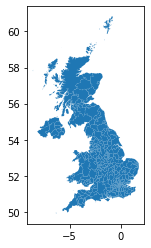

In [174]:
gdf.plot()